# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2023**. 
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection. 
Please complete and submit the **coding tasks** in a copy of **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 

## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**). 

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  




## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
The course is based on Tensorflow for data processing and MachineLearning. 
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains **3 sections**. 

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments). 

### Section 1 
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like. 

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package. 
There is no task for you here, but you will need to re-use some of this code later. 

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc. 
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud. 

### Section 2 
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report. 

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud. 

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells. 

### Imports

We import some **packages that will be needed throughout**. 
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below. 


In [3]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.12.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform. 

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work. 
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [4]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [5]:
PROJECT = 'disco-order-385609'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ### 
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = faiqbobcat@gmail.com
project = disco-order-385609
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems. 
**You must create your own bucket to have write access.**

In [6]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://disco-order-385609-storage/...
ServiceException: 409 A Cloud Storage bucket named 'disco-order-385609-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [6]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Install Spark locally for quick testing 

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**. 


In [7]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.2.0-bin-hadoop2.7.tgz" # unpack 

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.2.0-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.2.0
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning. 
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations. 

## 1.1 Getting started 

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [8]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data 

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [9]:

nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed). 
Below are **map functions** for these steps. 
You **don't need to study** the **internals of these functions** in detail. 

In [10]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [11]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)  

We can also look at some images using the image display function defined above (the one with the hidden code).

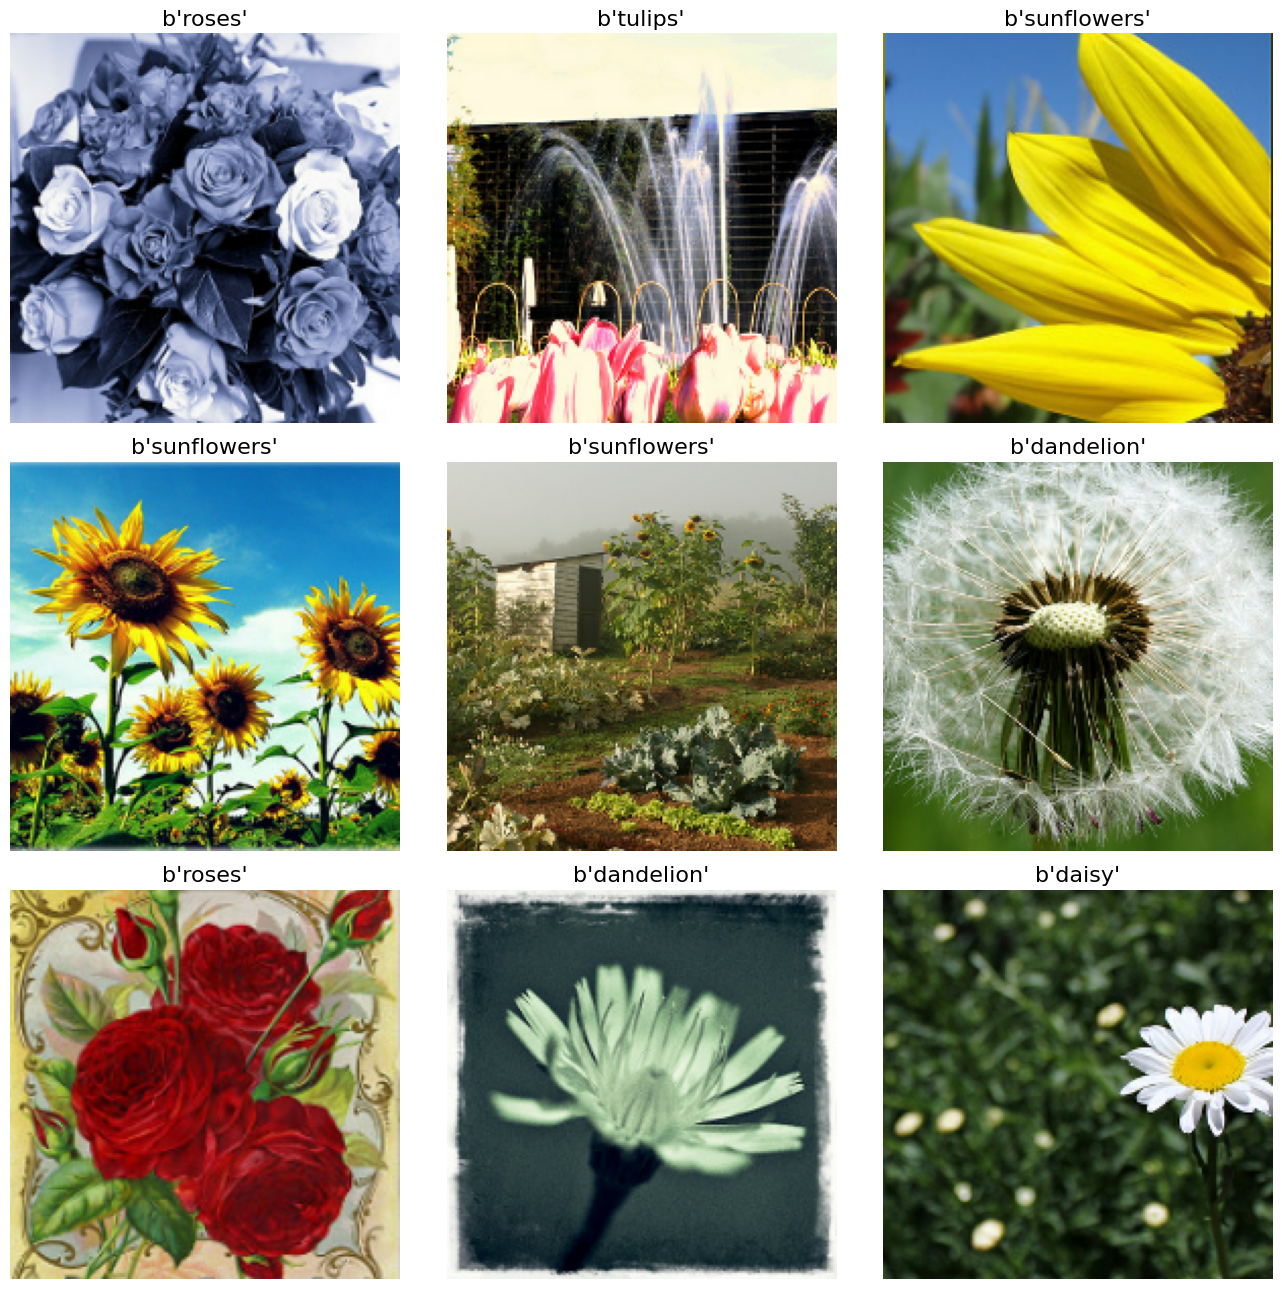

In [12]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [13]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'roses', 'dandelion', 'roses', 'roses'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'roses', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses', 'tulips'])
Image batch shape (10, 192, 192, 3), ['tulips', 'daisy', 'roses', 'daisy', 'sunflowers', 'dandelion', 'roses', 'daisy', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'sunflowers', 'roses', 'dandelion', 'dandelion', 'roses', 'dandelion', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'daisy', 'sunflowers', 'tulips', 'dandel

## 1.2 Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [14]:
# This is a quick test to get an idea how long recompressions takes.  
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (10,), ['roses', 'tulips', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers'])
Image batch shape (10,), ['sunflowers', 'roses', 'dandelion', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'tulips', 'tulips', 'dandelion'])
Image batch shape (10,), ['dandelion', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'tulips', 'daisy'])
Image batch shape (10,), ['tulips', 'roses', 'roses', 'tulips', 'roses', 'tulips', 'sunflowers', 'daisy', 'daisy', 'dandelion'])
Image batch shape (10,), ['roses', 'dandelion', 'tulips', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion'])
Image batch shape (10,), ['sunflowers', 'roses', 'tulips', 'dandelion', 'roses', 'daisy', 'tulips', 'daisy', 'tulips', 'roses'])
Image batch shape (10,), ['dandelion', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'roses', 'sunflowers', 'dandelion'])
Image batch shape (10,), 

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains. 
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used. 
First we need to **define a location** where we want to put the file. 

In [15]:

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail). 

There is a **ready-made pre-processed data** versions available here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing. 

In [16]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records 
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files. 
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)  
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://disco-order-385609-storage/tfrecords-jpeg-192x192-2/flowers08-230.tfrec contai

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [17]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [18]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '0', '3', '4', '2', '2', '3', '2', '0', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '3', '2', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['1', '3', '4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '2', '0', '0', '1', '4', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '0', '2', '3', '4', '2', '1', '1', '0'])
Image batch shape (10, 192, 192, 3), ['0', '1', '1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '1', '1', '1', '0', '1', '4', '3', '2'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets. 
This is a relatively straightforward case of **parallelisation**. 
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**. 

You need to: 

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. 
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%) 


In [19]:
### CODING TASK ### 
def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2


def resize_and_crop_image(label_img):
    image, label = label_img
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 


def recompress_image(label_img):
    # Extract the image tensor and label from the input tuple
    image, label = label_img
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label



In [20]:
filenames_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))

In [21]:
sampling_factor = 0.02 # Set sampling factor to a small value for short tests
sampled_filenames_rdd = filenames_rdd.sample(False, sampling_factor) # Randomly sample filenames_rdd using sampling_factor

# Use decode_jpeg_and_label function to decode the JPEG images and return them as a tuple of image and label
decoded_images_rdd = sampled_filenames_rdd.map(lambda filepath: decode_jpeg_and_label(filepath)) 

# Resize and crop images to a fixed size using the resize_and_crop_image function
resized_images_rdd = decoded_images_rdd.map(resize_and_crop_image)

# Recompress images using the recompress_image function to ensure that all images have the same format and size
preprocessed_images_rdd = resized_images_rdd.map(recompress_image)


In [22]:
def save_partition_to_tfrecord(index, partition):
    # Create a filename for the output TFRecord file based on the given partition index
    filename = f"preprocessed_images-partition-{index}.tfrecord"
    # Create the full output path by joining the Google Cloud Storage bucket name with the filename
    output_path = os.path.join("gs://disco-order-385609-storage/", filename)

    # Open a TFRecord writer for the output path
    with tf.io.TFRecordWriter(output_path) as writer:
        # Iterate over the images and labels in the given partition
        for image, label in partition:
            # Create a TF example for the current image and label
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
                        "label": tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.numpy()])),
                    }
                )
            )
            # Serialize the example to a string and write it to the TFRecord file
            writer.write(example.SerializeToString())

    # Return a list containing the output path of the written TFRecord file
    return [output_path]

# Map each partition of preprocessed images to a TFRecord file using the save_partition_to_tfrecord function,
# with each partition being assigned a unique index
tfrecord_filenames_rdd = preprocessed_images_rdd.mapPartitionsWithIndex(lambda index, partition: save_partition_to_tfrecord(index, partition))

# Collect the output file paths from the resulting RDD of TFRecord file names
tfrecord_filenames = tfrecord_filenames_rdd.collect()


In [23]:
def parse_tfrecord(tfrecord):
    # Define a dictionary specifying the features we expect to find in the TFRecord files
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }
    # Parse a single example from the input TFRecord file
    parsed_features = tf.io.parse_single_example(tfrecord, features)
    # Decode the JPEG-encoded image tensor
    image = tf.image.decode_jpeg(parsed_features['image'])
    # Get the label tensor as a string
    label = parsed_features['label']
    # Return the image and label tensors as a tuple
    return image, label

def load_dataset(tfrecord_filenames):
    # Create a TFRecordDataset from the input list of file names
    dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    # Apply the parse_tfrecord function to each element of the dataset
    dataset = dataset.map(parse_tfrecord)
    # Return the resulting dataset
    return dataset


In [24]:
def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13, 13))
    subplot = 331
    # Loop through the first 9 elements of the dataset and plot the images and labels
    for i, (image, label) in enumerate(dataset.take(9)):
        plt.subplot(subplot)
        plt.title(label.numpy().decode('utf-8'))
        # Show the image in the subplot
        plt.imshow(image.numpy().astype(np.uint8))
        plt.axis('off')
        subplot += 1
    plt.tight_layout()
    plt.show()
  

In [25]:
preprocessed_images_rdd.take(1)

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x00\x06\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x05\x06\x07\x04\x08\t\x00\n\xff\xc4\x00C\x10\x00\x01\x03\x02\x05\x02\x04\x04\x03\x07\x02\x04\x04\x07\x00\x00\x01\x02\x03\x04\x05\x11\x00\x06\x07\x12!\x081\x13"AQ\t\x14aq2\x81\x91\n\x15#B\xa1\xb1\xf0\x16R3Cb\x82%r\xc1\xe1\x17$S\x93\xa2\xd1\xf1\xff\xc4\x00\x1d\x01\x00\x02\x03\x01\x01\x01\x01\x01\x00\x0

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test. 


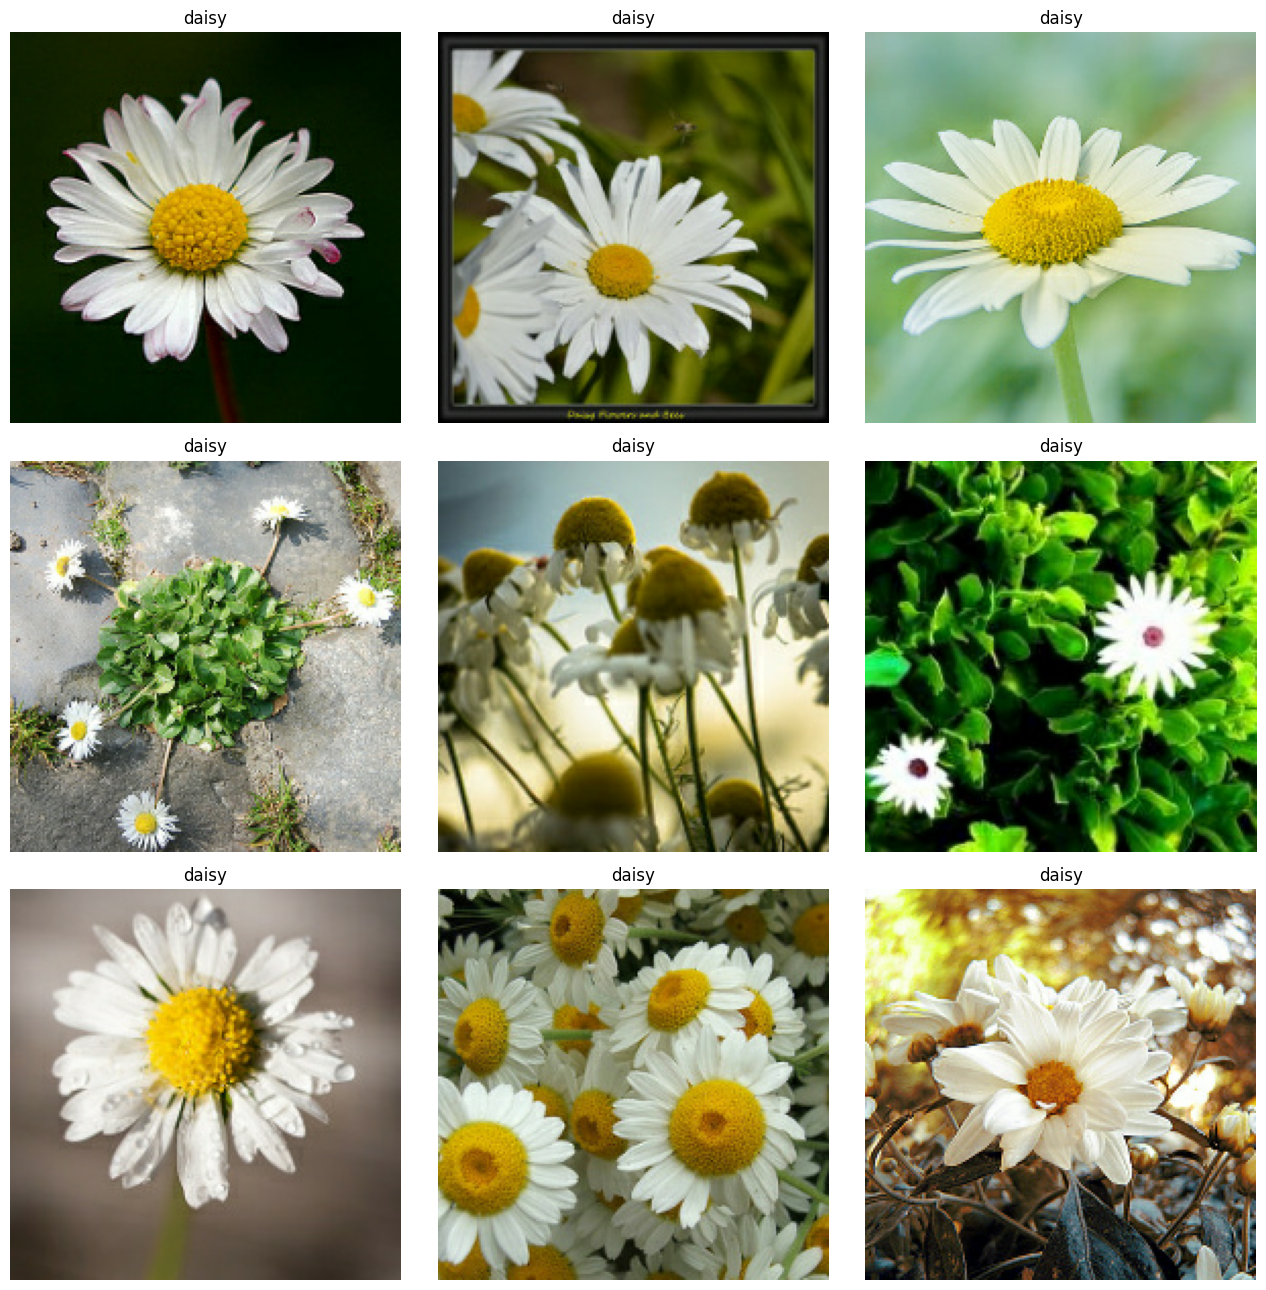

In [26]:
### CODING TASK ###
# Load the dataset from the TFRecord files
tfrecord_dataset = load_dataset(tfrecord_filenames)

# Display 9 images from the dataset
display_9_images_from_dataset(tfrecord_dataset)


ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark. 



In [27]:
%%writefile tfrec.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data 
    


def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2


def resize_and_crop_image(label_img):
    image, label = label_img
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 


def recompress_image(label_img):
    # Extract the image tensor and label from the input tuple
    image, label = label_img
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label

filenames = tf.io.gfile.glob(GCS_PATTERN)
#filenames_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))
filenames_rdd = sc.parallelize(filenames,PARTITIONS) ### TASK 1D ###
sampling_factor = 0.02 # Set sampling factor to a small value for short tests
sampled_filenames_rdd = filenames_rdd.sample(False, sampling_factor) # Randomly sample filenames_rdd using sampling_factor

# Use decode_jpeg_and_label function to decode the JPEG images and return them as a tuple of image and label
decoded_images_rdd = sampled_filenames_rdd.map(lambda filepath: decode_jpeg_and_label(filepath)) 

# Resize and crop images to a fixed size using the resize_and_crop_image function
resized_images_rdd = decoded_images_rdd.map(resize_and_crop_image)

# Recompress images using the recompress_image function to ensure that all images have the same format and size
preprocessed_images_rdd = resized_images_rdd.map(recompress_image)

def save_partition_to_tfrecord(index, partition):
    # Create a filename for the output TFRecord file based on the given partition index
    filename = f"preprocessed_images-partition-{index}.tfrecord"
    # Create the full output path by joining the Google Cloud Storage bucket name with the filename
    output_path = os.path.join("gs://disco-order-385609-storage/", filename)

    # Open a TFRecord writer for the output path
    with tf.io.TFRecordWriter(output_path) as writer:
        # Iterate over the images and labels in the given partition
        for image, label in partition:
            # Create a TF example for the current image and label
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
                        "label": tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.numpy()])),
                    }
                )
            )
            # Serialize the example to a string and write it to the TFRecord file
            writer.write(example.SerializeToString())

    # Return a list containing the output path of the written TFRecord file
    return [output_path]

# Map each partition of preprocessed images to a TFRecord file using the save_partition_to_tfrecord function,
# with each partition being assigned a unique index
tfrecord_filenames_rdd = preprocessed_images_rdd.mapPartitionsWithIndex(lambda index, partition: save_partition_to_tfrecord(index, partition))

# Collect the output file paths from the resulting RDD of TFRecord file names
tfrecord_filenames = tfrecord_filenames_rdd.collect()

def parse_tfrecord(tfrecord):
    # Define a dictionary specifying the features we expect to find in the TFRecord files
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }
    # Parse a single example from the input TFRecord file
    parsed_features = tf.io.parse_single_example(tfrecord, features)
    # Decode the JPEG-encoded image tensor
    image = tf.image.decode_jpeg(parsed_features['image'])
    # Get the label tensor as a string
    label = parsed_features['label']
    # Return the image and label tensors as a tuple
    return image, label

def load_dataset(tfrecord_filenames):
    # Create a TFRecordDataset from the input list of file names
    dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    # Apply the parse_tfrecord function to each element of the dataset
    dataset = dataset.map(parse_tfrecord)
    # Return the resulting dataset
    return dataset

def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13, 13))
    subplot = 331
    # Loop through the first 9 elements of the dataset and plot the images and labels
    for i, (image, label) in enumerate(dataset.take(9)):
        plt.subplot(subplot)
        plt.title(label.numpy().decode('utf-8'))
        # Show the image in the subplot
        plt.imshow(image.numpy().astype(np.uint8))
        plt.axis('off')
        subplot += 1
    plt.tight_layout()
    plt.show()
  

# Load the dataset from the TFRecord files
tfrecord_dataset = load_dataset(tfrecord_filenames)

# Display 9 images from the dataset
display_9_images_from_dataset(tfrecord_dataset)


Writing tfrec.py


Tensorflow version 2.12.0
3.2.0


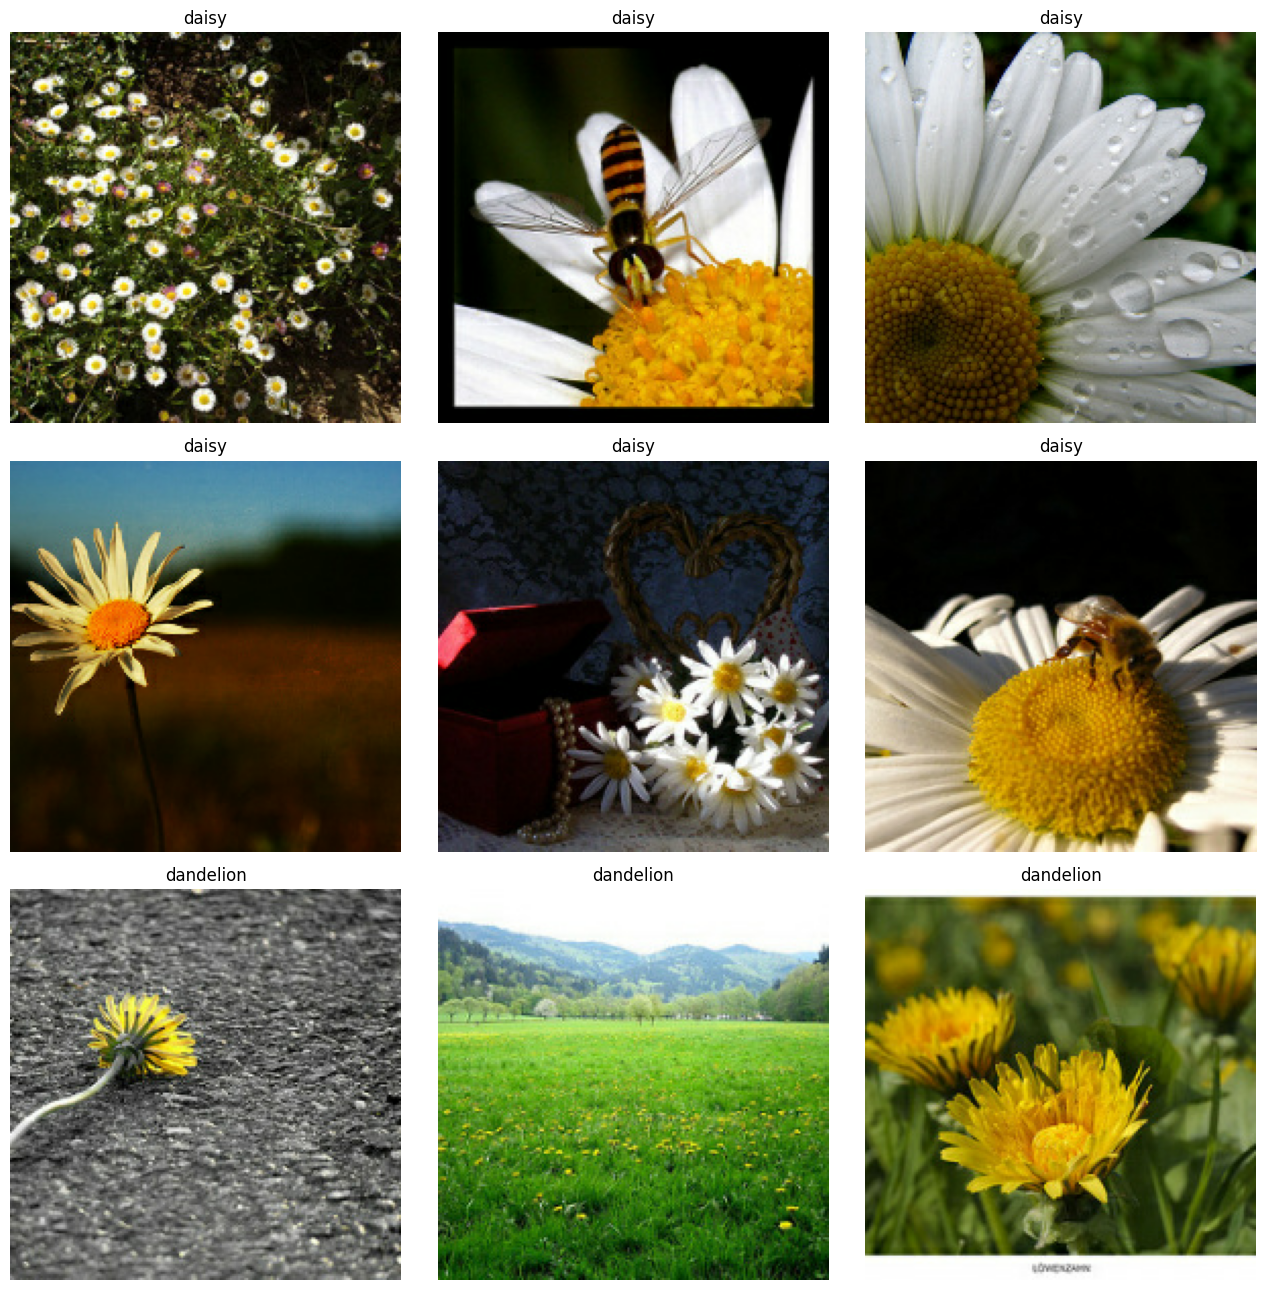

<Figure size 640x480 with 0 Axes>

In [28]:
%run tfrec.py

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs. 

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`. 

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [78]:
### CODING TASK ###
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --max-idle=+pt5m \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

Waiting on operation [projects/disco-order-385609/regions/us-central1/operations/2e51727c-2904-3d7d-a371-2f7ead7774e1].

Created [https://dataproc.googleapis.com/v1/projects/disco-order-385609/regions/us-central1/clusters/disco-order-385609-cluster] Cluster placed in zone [us-central1-b].


Run the script in the cloud and test the output. 

In [79]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
%time

Job [100cbcbebfc24909b58562180b05523d] submitted.
Waiting for job output...
2023-05-06 16:56:48.939507: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-06 16:56:48.939549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
23/05/06 16:56:52 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/06 16:56:52 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/06 16:56:52 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/06 16:56:52 INFO org.spark_project.jetty.util.log: Logging initialized @8568ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/06 16:56:52 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT;

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk* 
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**. 
Each of them with 1 (virtual) CPU. 
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

Once the cluster is running, test your script. (3%)

In [72]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --num-workers=7 \
    --worker-machine-type=n1-standard-1 \
    --worker-boot-disk-size=285GB \
    --worker-boot-disk-type=pd-standard \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-size=100GB \
    --master-boot-disk-type=pd-ssd \
    --image-version=1.5-ubuntu18 \
    --max-idle=1800s\
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

Waiting on operation [projects/disco-order-385609/regions/us-central1/operations/95219260-8fb2-3b5d-8127-7361924bf5f1].

Created [https://dataproc.googleapis.com/v1/projects/disco-order-385609/regions/us-central1/clusters/disco-order-385609-cluster1] Cluster placed in zone [us-central1-a].


In [73]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
%time

Job [1cd13808d60d4a2fb77a96a5d6fab114] submitted.
Waiting for job output...
2023-05-06 16:42:02.764050: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-06 16:42:02.764232: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
23/05/06 16:42:08 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/06 16:42:08 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/06 16:42:08 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/06 16:42:08 INFO org.spark_project.jetty.util.log: Logging initialized @15842ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/06 16:42:09 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation 

If you implemented a straightfoward version, you will 
**probably** observe that **all the computation** is done on only **two nodes**. 
This can be adressed by using the **second parameter** in the initial call to **parallelize**. 
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`. 

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources. 
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [81]:
%%writefile tfrec.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()


GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data 
    


def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2

def resize_and_crop_image(label_img):
    image, label = label_img
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 

def recompress_image(label_img):
    # Extract the image tensor and label from the input tuple
    image, label = label_img
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label

filenames = tf.io.gfile.glob(GCS_PATTERN)
#filenames_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))
filenames_rdd = sc.parallelize(filenames,PARTITIONS) ### TASK 1D ###
sampling_factor = 0.02 # Set sampling factor to a small value for short tests
sampled_filenames_rdd = filenames_rdd.sample(False, sampling_factor) # Randomly sample filenames_rdd using sampling_factor

# Use decode_jpeg_and_label function to decode the JPEG images and return them as a tuple of image and label
decoded_images_rdd = sampled_filenames_rdd.map(lambda filepath: decode_jpeg_and_label(filepath)) 

# Resize and crop images to a fixed size using the resize_and_crop_image function
resized_images_rdd = decoded_images_rdd.map(resize_and_crop_image)

# Recompress images using the recompress_image function to ensure that all images have the same format and size
preprocessed_images_rdd = resized_images_rdd.map(recompress_image)

def save_partition_to_tfrecord(index, partition):
    # Create a filename for the output TFRecord file based on the given partition index
    filename = f"preprocessed_images-partition-{index}.tfrecord"
    # Create the full output path by joining the Google Cloud Storage bucket name with the filename
    output_path = os.path.join("gs://disco-order-385609-storage/", filename)

    # Open a TFRecord writer for the output path
    with tf.io.TFRecordWriter(output_path) as writer:
        # Iterate over the images and labels in the given partition
        for image, label in partition:
            # Create a TF example for the current image and label
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
                        "label": tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.numpy()])),
                    }
                )
            )
            # Serialize the example to a string and write it to the TFRecord file
            writer.write(example.SerializeToString())

    # Return a list containing the output path of the written TFRecord file
    return [output_path]

# Map each partition of preprocessed images to a TFRecord file using the save_partition_to_tfrecord function,
# with each partition being assigned a unique index
tfrecord_filenames_rdd = preprocessed_images_rdd.mapPartitionsWithIndex(lambda index, partition: save_partition_to_tfrecord(index, partition))

# Collect the output file paths from the resulting RDD of TFRecord file names
tfrecord_filenames = tfrecord_filenames_rdd.collect()

def parse_tfrecord(tfrecord):
    # Define a dictionary specifying the features we expect to find in the TFRecord files
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }
    # Parse a single example from the input TFRecord file
    parsed_features = tf.io.parse_single_example(tfrecord, features)
    # Decode the JPEG-encoded image tensor
    image = tf.image.decode_jpeg(parsed_features['image'])
    # Get the label tensor as a string
    label = parsed_features['label']
    # Return the image and label tensors as a tuple
    return image, label

def load_dataset(tfrecord_filenames):
    # Create a TFRecordDataset from the input list of file names
    dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    # Apply the parse_tfrecord function to each element of the dataset
    dataset = dataset.map(parse_tfrecord)
    # Return the resulting dataset
    return dataset

def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13, 13))
    subplot = 331
    # Loop through the first 9 elements of the dataset and plot the images and labels
    for i, (image, label) in enumerate(dataset.take(9)):
        plt.subplot(subplot)
        plt.title(label.numpy().decode('utf-8'))
        # Show the image in the subplot
        plt.imshow(image.numpy().astype(np.uint8))
        plt.axis('off')
        subplot += 1
    plt.tight_layout()
    plt.show()
  

# Load the dataset from the TFRecord files
tfrecord_dataset = load_dataset(tfrecord_filenames)

# Display 9 images from the dataset
display_9_images_from_dataset(tfrecord_dataset)


Overwriting tfrec.py


1)d)i) Single machine cluster with partition

In [ ]:

CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --max-idle=+pt5m \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
%time

1)d)i) Maximal cluster with partition to improve parallelization

In [ ]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --num-workers=7 \
    --worker-machine-type=n1-standard-1 \
    --worker-boot-disk-size=285GB \
    --worker-boot-disk-type=pd-standard \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-size=100GB \
    --master-boot-disk-type=pd-ssd \
    --image-version=1.5-ubuntu18 \
    --max-idle=1800s\
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
%time

1)d)ii) Different cluster configuration experiments

In [ ]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --num-workers=3 \
    --worker-machine-type=n1-standard-2 \
    --worker-boot-disk-size=500GB \
    --master-machine-type=n1-standard-2 \
    --master-boot-disk-size=100GB \
    --image-version=1.5-ubuntu18 \
    --max-idle=1800s\
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"
# configuration for cluster with 4 machines with double the resources each 


Waiting on operation [projects/disco-order-385609/regions/us-central1/operations/4697691d-7b3e-3e5d-b533-741ed936ceff].

Created [https://dataproc.googleapis.com/v1/projects/disco-order-385609/regions/us-central1/clusters/disco-order-385609-cluster1] Cluster placed in zone [us-central1-a].


In [ ]:
 !gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
 %time

Job [23c55503a2f34752ac793cf698861ad4] submitted.
Waiting for job output...
2023-05-05 16:24:45.039770: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-05 16:24:45.039816: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
23/05/05 16:24:49 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/05 16:24:49 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/05 16:24:49 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/05 16:24:49 INFO org.spark_project.jetty.util.log: Logging initialized @11553ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/05 16:24:49 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

In [ ]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-16 \
    --master-boot-disk-size 100 \
    --max-idle=+pt5m \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

# single machine with eightfold resources
    

Waiting on operation [projects/disco-order-385609/regions/us-central1/operations/db77de24-126d-3411-a484-7deee2696708].

Created [https://dataproc.googleapis.com/v1/projects/disco-order-385609/regions/us-central1/clusters/disco-order-385609-cluster1] Cluster placed in zone [us-central1-b].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./tfrec.py
%time

Job [6ec54e42964c4d27ae85748624a0d406] submitted.
Waiting for job output...
2023-05-05 17:28:04.581056: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-05 17:28:04.581099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
23/05/05 17:28:07 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/05 17:28:07 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/05 17:28:07 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/05 17:28:07 INFO org.spark_project.jetty.util.log: Logging initialized @8699ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/05 17:28:07 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT;

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **measuring this effect** and **parallelizing the tests with PySpark**. 

## 2.1 Speed test implementation 

Here is **code for time measurement** to determine the **throughput in images per second**. 
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read. 
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`. 
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`). 
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings. 

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions. 

In [29]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4] 
batch_numbers = [3,6] 
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec). 

In [30]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res) 
print(par) 

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'tulips'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
I

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc. 
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [29]:
import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__) #import tensorflow
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext


# define variables before starting task 
PROJECT = 'disco-order-385609'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)
    



Tensorflow version 2.12.0


In [30]:
def generate_param_combinations(batch_sizes, batch_numbers, repetitions):
    """
    This functions generates tuples that aim at representing all possible combinations of batch sizes, batch numbers, and repetitions.
    
    :param batch_sizes: a list of integers representing batch sizes.
    :param batch_numbers: a list of integers representing batch numbers.
    :param repetitions: a list of integers representing repetition numbers.
    :return: a list of tuples representing parameter combinations.
    """
    param_combinations = []
    for bs in batch_sizes:
        for bn in batch_numbers:
            for r in repetitions:
                param_combinations.append((bs, bn, r))
    return param_combinations

def generate_param_combinations_rdd(param_combinations):
    conf = SparkConf().setAppName("ThroughputTest").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    return sc.parallelize(param_combinations)

# Initial parameters to be used
batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 12]
repetitions = [1, 2, 3]

# Generate a list of parameter combinations
param_combinations = generate_param_combinations(batch_sizes, batch_numbers, repetitions)

# Convert the list to an RDD
param_combinations_rdd = generate_param_combinations_rdd(param_combinations)

In [31]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


In [32]:
def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2


def resize_and_crop_image(image,label):
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 


def recompress_image(image,label):
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label

def load_dataset_images():
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image) 
    return dsetResized


In [33]:
# Define the time configuration test function for tfrecord dataset
def time_configs_tfrecord(params):
    bs, ds, rep = params
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetTfrec = load_dataset(filenames)
    batched_dataset = datasetTfrec.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

# Define the time configuration test function for images dataset
def time_configs_images(params):
    bs, ds, rep = params
    datasetimage = load_dataset_images()
    batched_dataset = datasetimage.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

In [45]:
# This code collects and prints results for the TensorFlow dataset which is the first to be used

# Call the time_configs_tfrecord function for each set of parameter combinations and store the results in a list
results = [time_configs_tfrecord(params) for params in param_combinations_list]

import pandas as pd
# Create an empty list to hold the results data
results_list = []
#Iterate through the results list and add each set of results as a dictionary to the results_list
print("Results for TFrecord:")
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})
# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)
# Print the results DataFrame
print(results_df)


Results for TFrecord:
        params  reading_speed  throughput
0    (2, 3, 1)       0.128685   46.625654
1    (2, 3, 2)       0.284216   21.110675
2    (2, 3, 3)       0.389426   15.407301
3    (2, 6, 1)       0.121903   98.438584
4    (2, 6, 2)       0.320514   37.439811
5    (2, 6, 3)       0.460141   26.078979
6   (2, 12, 1)       0.134093  178.980517
7   (2, 12, 2)       0.284994   84.212403
8   (2, 12, 3)       1.521430   15.774628
9    (4, 3, 1)       0.189918   63.185071
10   (4, 3, 2)       1.481124    8.101955
11   (4, 3, 3)       0.711085   16.875629
12   (4, 6, 1)       0.112348  213.622262
13   (4, 6, 2)       0.261702   91.707341
14   (4, 6, 3)       0.357626   67.109132
15  (4, 12, 1)       0.131522  364.958120
16  (4, 12, 2)       0.279913  171.481885
17  (4, 12, 3)       0.380956  125.998825
18   (6, 3, 1)       0.126287  142.532235
19   (6, 3, 2)       0.236275   76.182274
20   (6, 3, 3)       0.452621   39.768331
21   (6, 6, 1)       0.123651  291.142501
22   (6, 6, 

In [46]:
# Now, this code collects and prints results for the images dataset which will be compared
# Call the time_configs_images function for each set of parameter combinations and store the results in a list
results = [time_configs_images(params) for params in param_combinations_list]

# Convert the results list into a pandas DataFrame for further analysis and visualization
import pandas as pd

# Create an empty list to hold the results data
results_list = []

# Iterate through the results list and add each set of results as a dictionary to the results_list
print("Images results:")
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})

# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Print the results DataFrame
print(results_df)


Images results:
        params  reading_speed  throughput
0    (2, 3, 1)       0.447904   13.395739
1    (2, 3, 2)       0.943458    6.359585
2    (2, 3, 3)       1.041981    5.758264
3    (2, 6, 1)       0.930002   12.903195
4    (2, 6, 2)       1.386405    8.655481
5    (2, 6, 3)       2.058085    5.830663
6   (2, 12, 1)       1.068156   22.468618
7   (2, 12, 2)       1.956978   12.263805
8   (2, 12, 3)       3.065687    7.828589
9    (4, 3, 1)       0.780532   15.374136
10   (4, 3, 2)       1.448002    8.287282
11   (4, 3, 3)       1.788128    6.710928
12   (4, 6, 1)       1.199139   20.014358
13   (4, 6, 2)       1.837288   13.062731
14   (4, 6, 3)       2.737747    8.766331
15  (4, 12, 1)       2.287757   20.981250
16  (4, 12, 2)       3.772808   12.722621
17  (4, 12, 3)       5.613295    8.551127
18   (6, 3, 1)       0.884051   20.360820
19   (6, 3, 2)       2.307737    7.799850
20   (6, 3, 3)       2.667102    6.748899
21   (6, 6, 1)       1.363485   26.402938
22   (6, 6, 2)    

In [36]:
# This code defines functions for calculating average reading speeds from a results RDD

# Define a function to merge reading speeds
def merge_speeds(a, b):
    return a[0] + b[0], a[1] + b[1]

# Define a function to calculate average reading speeds
def calculate_avg_speeds(results_rdd):
    # Map each result to a tuple with the parameters and a tuple containing the reading speed and a count of 1
    mapped_results = results_rdd.map(lambda x: (x[2], (x[0], 1)))
    
    # Reduce the mapped results by key (i.e., by parameter combination) and merge the reading speeds
    reduced_speeds = mapped_results.reduceByKey(merge_speeds)
    
    # Map the reduced speeds to a tuple with the parameters and the average reading speed
    avg_speeds = reduced_speeds.mapValues(lambda x: x[0] / x[1]).collect()
    
    return avg_speeds

# Calculate the results of the TFRecord dataset
tfrecord_results = [time_configs_tfrecord(params) for params in param_combinations_list]  # time the TFRecord dataset for each parameter combination
tfrecord_rdd = sc.parallelize(tfrecord_results)  # create an RDD for the TFRecord results
tfrecord_avg_speeds = calculate_avg_speeds(tfrecord_rdd)  # calculate the average reading speeds for the TFRecord dataset

# Print the average reading speeds for the TFRecord dataset
print("Average reading speeds for the TFRecord dataset:")
for params, avg_speed in tfrecord_avg_speeds:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(params, avg_speed))

# Calculate the results of the images dataset
results_images = [time_configs_images(params) for params in param_combinations_list]
results_rdd_images = sc.parallelize(results_images)
avg_speeds_images = calculate_avg_speeds(results_rdd_images)

print("\nAverage reading speeds for Images:")
for param_combination, avg_speed in avg_speeds_images:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(param_combination, avg_speed))


Average reading speeds for the TFRecord dataset:
Parameter Combination: (2, 3, 2), Average Reading Speed: 0.30
Parameter Combination: (2, 6, 1), Average Reading Speed: 0.15
Parameter Combination: (2, 6, 3), Average Reading Speed: 0.48
Parameter Combination: (2, 12, 1), Average Reading Speed: 0.15
Parameter Combination: (2, 12, 3), Average Reading Speed: 0.39
Parameter Combination: (4, 3, 2), Average Reading Speed: 0.28
Parameter Combination: (4, 6, 1), Average Reading Speed: 0.12
Parameter Combination: (4, 6, 3), Average Reading Speed: 0.39
Parameter Combination: (4, 12, 1), Average Reading Speed: 0.16
Parameter Combination: (4, 12, 3), Average Reading Speed: 0.47
Parameter Combination: (6, 3, 2), Average Reading Speed: 0.42
Parameter Combination: (6, 6, 1), Average Reading Speed: 0.15
Parameter Combination: (6, 6, 3), Average Reading Speed: 0.38
Parameter Combination: (6, 12, 1), Average Reading Speed: 0.17
Parameter Combination: (6, 12, 3), Average Reading Speed: 0.49
Parameter Combi

In [37]:
import subprocess

def write_results_to_pickle(results, file_name):
    # Serialize the results
    serialized_results = pickle.dumps(results)

    # Save the serialized results as a local pickle file
    with open(file_name, 'wb') as f:
        f.write(serialized_results)

    # Upload the local pickle file to the GCS storage bucket
    gsutil_command = f"gsutil cp {file_name} {BUCKET}/{file_name}"
    subprocess.run(gsutil_command, shell=True, check=True)

    print(f"Results have been uploaded to {BUCKET}/{file_name}")

# Combine the results into a dictionary
tfrecord_results = {'results': tfrecord_results, 'avg_speeds': tfrecord_avg_speeds}
images_results = {'results': results_images, 'avg_speeds': avg_speeds_images}

# Use the function to upload the results to the GCS storage bucket
write_results_to_pickle(tfrecord_results, 'tfrecord_results.pickle')
write_results_to_pickle(images_results, 'images_results.pickle')

Results have been uploaded to gs://disco-order-385609-storage/tfrecord_results.pickle
Results have been uploaded to gs://disco-order-385609-storage/images_results.pickle


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten. 

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [57]:
%%writefile speedtest.py  
import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import subprocess
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__) #import tensorflow
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

sc = pyspark.SparkContext.getOrCreate()
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
PROJECT = 'disco-order-385609'
BUCKET = 'gs://{}-storage'.format(PROJECT) 

def generate_param_combinations(batch_sizes, batch_numbers, repetitions):
    """
    Generate a list of tuples representing all possible combinations of batch sizes, batch numbers, and repetitions.
    
    :param batch_sizes: a list of integers representing batch sizes.
    :param batch_numbers: a list of integers representing batch numbers.
    :param repetitions: a list of integers representing repetition numbers.
    :return: a list of tuples representing parameter combinations.
    """
    param_combinations = []
    for bs in batch_sizes:
        for bn in batch_numbers:
            for r in repetitions:
                param_combinations.append((bs, bn, r))
    return param_combinations


# This code converts a list of parameter combinations to an RDD

from pyspark import SparkConf, SparkContext

def generate_param_combinations_rdd(param_combinations):
    """
    Convert a list of parameter combinations to an RDD using Apache Spark.
    
    :param param_combinations: a list of tuples representing parameter combinations.
    :return: an RDD of tuples representing parameter combinations.
    """
    # Set up the Spark configuration and context
    conf = SparkConf().setAppName("ThroughputTest").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    
    # Convert the list to an RDD
    return sc.parallelize(param_combinations)


# Example usage of the above functions
batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 12]
repetitions = [1, 2, 3]

# Generate a list of parameter combinations
param_combinations = generate_param_combinations(batch_sizes, batch_numbers, repetitions)
# Convert the list to an RDD
param_combinations_rdd = generate_param_combinations_rdd(param_combinations)

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2


def resize_and_crop_image(image,label):
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 


def recompress_image(image,label):
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label

def load_dataset_images():
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image) 
    return dsetResized

# Define the time configuration test function for tfrecord dataset
def time_configs_tfrecord(params):
    bs, ds, rep = params
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetTfrec = load_dataset(filenames)
    batched_dataset = datasetTfrec.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

# Define the time configuration test function for images dataset
def time_configs_images(params):
    bs, ds, rep = params
    datasetimage = load_dataset_images()
    batched_dataset = datasetimage.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

# This code collects and prints results for the TensorFlow dataset which is the first to be used

# Call the time_configs_tfrecord function for each set of parameter combinations and store the results in a list
results = [time_configs_tfrecord(params) for params in param_combinations_list]

import pandas as pd
# Create an empty list to hold the results data
results_list = []
#Iterate through the results list and add each set of results as a dictionary to the results_list
print("Results for TFrecord:")
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})
# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)
# Print the results DataFrame
print(results_df)

# Now, this code collects and prints results for the images dataset which will be compared
# Call the time_configs_images function for each set of parameter combinations and store the results in a list
results = [time_configs_images(params) for params in param_combinations_list]

# Convert the results list into a pandas DataFrame for further analysis and visualization
import pandas as pd

# Create an empty list to hold the results data
results_list = []

# Iterate through the results list and add each set of results as a dictionary to the results_list
print("Images results:")
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})

# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Print the results DataFrame
print(results_df)


# This code defines functions for calculating average reading speeds from a results RDD

# Define a function to merge reading speeds
def merge_speeds(a, b):
    return a[0] + b[0], a[1] + b[1]

# Define a function to calculate average reading speeds
def calculate_avg_speeds(results_rdd):
    # Map each result to a tuple with the parameters and a tuple containing the reading speed and a count of 1
    mapped_results = results_rdd.map(lambda x: (x[2], (x[0], 1)))
    
    # Reduce the mapped results by key (i.e., by parameter combination) and merge the reading speeds
    reduced_speeds = mapped_results.reduceByKey(merge_speeds)
    
    # Map the reduced speeds to a tuple with the parameters and the average reading speed
    avg_speeds = reduced_speeds.mapValues(lambda x: x[0] / x[1]).collect()
    
    return avg_speeds

# Calculate the results of the TFRecord dataset
tfrecord_results = [time_configs_tfrecord(params) for params in param_combinations_list]  # time the TFRecord dataset for each parameter combination
tfrecord_rdd = sc.parallelize(tfrecord_results)  # create an RDD for the TFRecord results
tfrecord_avg_speeds = calculate_avg_speeds(tfrecord_rdd)  # calculate the average reading speeds for the TFRecord dataset

# Print the average reading speeds for the TFRecord dataset
print("Average reading speeds for the TFRecord dataset:")
for params, avg_speed in tfrecord_avg_speeds:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(params, avg_speed))

# Calculate the results of the images dataset
results_images = [time_configs_images(params) for params in param_combinations_list]
results_rdd_images = sc.parallelize(results_images)
avg_speeds_images = calculate_avg_speeds(results_rdd_images)

print("\nAverage reading speeds for Images:")
for param_combination, avg_speed in avg_speeds_images:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(param_combination, avg_speed))

def write_results_to_pickle(results, file_name):
    # Serialize the results
    serialized_results = pickle.dumps(results)

    # Save the serialized results as a local pickle file
    with open(file_name, 'wb') as f:
        f.write(serialized_results)

    # Upload the local pickle file to the GCS storage bucket
    gsutil_command = f"gsutil cp {file_name} {BUCKET}/{file_name}"
    subprocess.run(gsutil_command, shell=True, check=True)

    print(f"Results have been uploaded to {BUCKET}/{file_name}")

# Combine the results into a dictionary
tfrecord_results = {'results': tfrecord_results, 'avg_speeds': tfrecord_avg_speeds}
images_results = {'results': results_images, 'avg_speeds': avg_speeds_images}

# Use the function to upload the results to the GCS storage bucket
write_results_to_pickle(tfrecord_results, 'tfrecord_results.pickle')
write_results_to_pickle(images_results, 'images_results.pickle')

Overwriting speedtest.py


In [58]:
%run speedtest.py


Tensorflow version 2.12.0
Results for TFrecord:
        params  reading_speed  throughput
0    (2, 3, 1)       0.192369   31.190098
1    (2, 3, 2)       0.298089   20.128215
2    (2, 3, 3)       0.481996   12.448247
3    (2, 6, 1)       0.169492   70.799700
4    (2, 6, 2)       0.261799   45.836633
5    (2, 6, 3)       0.413983   28.986707
6   (2, 12, 1)       0.137155  174.984131
7   (2, 12, 2)       0.260826   92.015496
8   (2, 12, 3)       0.385130   62.316670
9    (4, 3, 1)       0.162988   73.624860
10   (4, 3, 2)       0.257011   46.690620
11   (4, 3, 3)       0.500819   23.960765
12   (4, 6, 1)       0.176201  136.208184
13   (4, 6, 2)       0.333728   71.914888
14   (4, 6, 3)       0.513764   46.714042
15  (4, 12, 1)       0.187809  255.579144
16  (4, 12, 2)       0.397616  120.719371
17  (4, 12, 3)       0.561428   85.496332
18   (6, 3, 1)       0.139013  129.484244
19   (6, 3, 2)       0.326100   55.197733
20   (6, 3, 3)       0.437782   41.116372
21   (6, 6, 1)       0.13081

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud. 

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. 


In [59]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-16 \
    --master-boot-disk-size 100 \
    --max-idle=+pt5m \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

# single machine with eightfold resources

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'CPUS' quota. Requested 16.0, available 8.0.


In [60]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./speedtest.py
%time

Job [ee45437422224ed39d5c72af2c297bef] submitted.
Waiting for job output...
2023-05-07 07:46:12.749708: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-07 07:46:12.749757: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
23/05/07 07:46:15 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/07 07:46:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/07 07:46:15 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/07 07:46:15 INFO org.spark_project.jetty.util.log: Logging initialized @4553ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/07 07:46:15 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code. 

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`. 

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect** 

In [ ]:
%%writefile speedtest.py  
import os, sys, math
import numpy as np
# import scipy as sp
# import scipy.stats
import subprocess
import time
import datetime
import string
import random
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__) #import tensorflow
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

sc = pyspark.SparkContext.getOrCreate()
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
PROJECT = 'disco-order-385609'
BUCKET = 'gs://{}-storage'.format(PROJECT) 

def generate_param_combinations(batch_sizes, batch_numbers, repetitions):
    """
    Generate a list of tuples representing all possible combinations of batch sizes, batch numbers, and repetitions.
    
    :param batch_sizes: a list of integers representing batch sizes.
    :param batch_numbers: a list of integers representing batch numbers.
    :param repetitions: a list of integers representing repetition numbers.
    :return: a list of tuples representing parameter combinations.
    """
    param_combinations = []
    for bs in batch_sizes:
        for bn in batch_numbers:
            for r in repetitions:
                param_combinations.append((bs, bn, r))
    return param_combinations


# This code converts a list of parameter combinations to an RDD

from pyspark import SparkConf, SparkContext

def generate_param_combinations_rdd(param_combinations):
    """
    Convert a list of parameter combinations to an RDD using Apache Spark.
    
    :param param_combinations: a list of tuples representing parameter combinations.
    :return: an RDD of tuples representing parameter combinations.
    """
    # Set up the Spark configuration and context
    conf = SparkConf().setAppName("ThroughputTest").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    
    # Convert the list to an RDD
    return sc.parallelize(param_combinations)


# Example usage of the above functions
batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 12]
repetitions = [1, 2, 3]

# Generate a list of parameter combinations
param_combinations = generate_param_combinations(batch_sizes, batch_numbers, repetitions)
# Convert the list to an RDD
param_combinations_rdd = generate_param_combinations_rdd(param_combinations)

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.cache() ### TASK 2C ###
    return dataset

def decode_jpeg_and_label(filepath):
    # Read the contents of the file at the given filepath
    bits = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image data into a tensor
    image = tf.image.decode_jpeg(bits)
    # Split the filepath string by '/' characters to extract the label
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    # Get the second-to-last element of the resulting string tensor to extract the label directory
    label2 = label.values[-2]
    # Return the image tensor and the extracted label directory as strings
    return image, label2


def resize_and_crop_image(image,label):
    # Get the width and height of the input image tensor
    width = tf.shape(image)[0]
    height = tf.shape(image)[1]
    # Get the target width and height from the global variable TARGET_SIZE
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    # Compute the resize ratio based on the aspect ratios of the input image and the target size
    resize_ratio = (width * target_height) / (height * target_width)
    # Use a TensorFlow conditional statement to resize the image tensor based on the resize ratio
    image = tf.cond(resize_ratio < 1,
                  # If the resize ratio is less than 1, resize the image to the target width while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_width/width, height*target_width/width]),
                  # If the resize ratio is greater than or equal to 1, resize the image to the target height while preserving aspect ratio
                  lambda: tf.image.resize(image, [width*target_height/height, height*target_height/height])
                  )
    # Get the new width and height of the resized image tensor
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    # Use TensorFlow's crop_to_bounding_box function to crop the resized image tensor to the target size
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    # Return the cropped image tensor and the input label tensor
    return image, label 


def recompress_image(image,label):
    # Convert the image tensor to an 8-bit unsigned integer tensor
    image = tf.cast(image, tf.uint8)
    # Encode the image tensor as a JPEG-encoded image with optimized file size and no chroma downsampling
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    # Return the JPEG-encoded image tensor and the label tensor
    return image, label

def load_dataset_images():
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image) 
    dsetResized = dsetResized.cache() ### TASK 2C ###
    return dsetResized

# Define the time configuration test function for tfrecord dataset
def time_configs_tfrecord(params):
    bs, ds, rep = params
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetTfrec = load_dataset(filenames)
    batched_dataset = datasetTfrec.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

# Define the time configuration test function for images dataset
def time_configs_images(params):
    bs, ds, rep = params
    datasetimage = load_dataset_images()
    batched_dataset = datasetimage.batch(bs)
    timing_set = batched_dataset.take(ds)
    t0 = time.time()
    for _ in range(rep):
        for image, label in timing_set:
            pass
    reading_speed = time.time() - t0
    throughput = (bs * ds) / reading_speed
    return reading_speed, throughput, params

# Mapping timing tests to parameter combination RDDs
param_combinations_list = param_combinations_rdd.collect()

# This code collects and prints results for the TensorFlow dataset which is the first to be used

# Call the time_configs_tfrecord function for each set of parameter combinations and store the results in a list
results = [time_configs_tfrecord(params) for params in param_combinations_list]
# Iterate through the results list and print the parameters, reading speed, and throughput for each set of parameter combinations
for rs, tp, prms in results:
    print("Parameters: {}, Reading Speed: {:.2f}, Throughput: {:.2f}".format(prms, rs, tp)) 
# Convert the results list into a pandas DataFrame for further analysis and visualization
import pandas as pd
# Create an empty list to hold the results data
results_list = []
#Iterate through the results list and add each set of results as a dictionary to the results_list
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})
# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)
# Print the results DataFrame
print(results_df)

# Now, this code collects and prints results for the images dataset which will be compared

# Call the time_configs_images function for each set of parameter combinations and store the results in a list
results = [time_configs_images(params) for params in param_combinations_list]

# Iterate through the results list and print the parameters, reading speed, and throughput for each set of parameter combinations
for rs, tp, prms in results:
    print("Parameters: {}, Reading Speed: {:.2f}, Throughput: {:.2f}".format(prms, rs, tp)) 

# Convert the results list into a pandas DataFrame for further analysis and visualization
import pandas as pd

# Create an empty list to hold the results data
results_list = []

# Iterate through the results list and add each set of results as a dictionary to the results_list
for result in results:
    rs, tp, prms = result
    results_list.append({'params': prms, 'reading_speed': rs, 'throughput': tp})

# Convert the results_list to a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Print the results DataFrame
print(results_df)

# This code defines functions for calculating average reading speeds from a results RDD

# Define a function to merge reading speeds
def merge_speeds(a, b):
    return a[0] + b[0], a[1] + b[1]

# Define a function to calculate average reading speeds
def calculate_avg_speeds(results_rdd):
    # Map each result to a tuple with the parameters and a tuple containing the reading speed and a count of 1
    mapped_results = results_rdd.map(lambda x: (x[2], (x[0], 1)))
    
    # Reduce the mapped results by key (i.e., by parameter combination) and merge the reading speeds
    reduced_speeds = mapped_results.reduceByKey(merge_speeds)
    
    # Map the reduced speeds to a tuple with the parameters and the average reading speed
    avg_speeds = reduced_speeds.mapValues(lambda x: x[0] / x[1]).collect()
    
    return avg_speeds

# Calculate the results of the TFRecord dataset
tfrecord_results = [time_configs_tfrecord(params) for params in param_combinations_list]  # time the TFRecord dataset for each parameter combination
tfrecord_rdd = sc.parallelize(tfrecord_results)  # create an RDD for the TFRecord results
tfrecord_avg_speeds = calculate_avg_speeds(tfrecord_rdd)  # calculate the average reading speeds for the TFRecord dataset

# Print the average reading speeds for the TFRecord dataset
print("Average reading speeds for the TFRecord dataset:")
for params, avg_speed in tfrecord_avg_speeds:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(params, avg_speed))

# Calculate the results of the images dataset
results_images = [time_configs_images(params) for params in param_combinations_list]
results_rdd_images = sc.parallelize(results_images)
avg_speeds_images = calculate_avg_speeds(results_rdd_images)

print("\nAverage reading speeds for Images:")
for param_combination, avg_speed in avg_speeds_images:
    print("Parameter Combination: {}, Average Reading Speed: {:.2f}".format(param_combination, avg_speed))

def write_results_to_pickle(results, file_name):
    # Serialize the results
    serialized_results = pickle.dumps(results)

    # Save the serialized results as a local pickle file
    with open(file_name, 'wb') as f:
        f.write(serialized_results)

    # Upload the local pickle file to the GCS storage bucket
    gsutil_command = f"gsutil cp {file_name} {BUCKET}/{file_name}"
    subprocess.run(gsutil_command, shell=True, check=True)

    print(f"Results have been uploaded to {BUCKET}/{file_name}")

# Combine the results into a dictionary
tfrecord_results = {'results': tfrecord_results, 'avg_speeds': tfrecord_avg_speeds}
images_results = {'results': results_images, 'avg_speeds': avg_speeds_images}

# Use the function to upload the results to the GCS storage bucket
write_results_to_pickle(tfrecord_results, 'tfrecord_results.pickle')
write_results_to_pickle(images_results, 'images_results.pickle')

In [40]:
%run speedtest.py


Tensorflow version 2.12.0
Parameters: (2, 3, 1), Reading Speed: 0.14, Throughput: 42.96
Parameters: (2, 3, 2), Reading Speed: 0.32, Throughput: 18.55
Parameters: (2, 3, 3), Reading Speed: 0.36, Throughput: 16.56
Parameters: (2, 6, 1), Reading Speed: 0.13, Throughput: 94.32
Parameters: (2, 6, 2), Reading Speed: 0.30, Throughput: 40.22
Parameters: (2, 6, 3), Reading Speed: 0.42, Throughput: 28.33
Parameters: (2, 12, 1), Reading Speed: 0.13, Throughput: 189.44
Parameters: (2, 12, 2), Reading Speed: 0.27, Throughput: 88.13
Parameters: (2, 12, 3), Reading Speed: 0.38, Throughput: 62.73
Parameters: (4, 3, 1), Reading Speed: 0.12, Throughput: 101.46
Parameters: (4, 3, 2), Reading Speed: 0.29, Throughput: 41.71
Parameters: (4, 3, 3), Reading Speed: 0.46, Throughput: 26.17
Parameters: (4, 6, 1), Reading Speed: 0.19, Throughput: 127.28
Parameters: (4, 6, 2), Reading Speed: 0.33, Throughput: 72.70
Parameters: (4, 6, 3), Reading Speed: 0.43, Throughput: 55.42
Parameters: (4, 12, 1), Reading Speed:

In [41]:
CLUSTER = '{}-cluster1'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-16 \
    --master-boot-disk-size 100 \
    --max-idle=+pt5m \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 numpy matplotlib protobuf==3.20.0"

# single machine with eightfold resources

Waiting on operation [projects/disco-order-385609/regions/us-central1/operations/84a43672-fd46-30d4-a786-c2c2c00fed30].

Created [https://dataproc.googleapis.com/v1/projects/disco-order-385609/regions/us-central1/clusters/disco-order-385609-cluster1] Cluster placed in zone [us-central1-b].


In [42]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./speedtest.py
%time

Job [0be6dd5b0dc24ac88aba559d9d3cb38f] submitted.
Waiting for job output...
2023-05-07 06:28:06.804303: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2023-05-07 06:28:06.804355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
23/05/07 06:28:10 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/07 06:28:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/07 06:28:10 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/07 06:28:10 INFO org.spark_project.jetty.util.log: Logging initialized @5831ms to org.spark_project.jetty.util.log.Slf4jLog
23/05/07 06:28:10 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table. 

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files). 
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning. 
Keep in mind that cloud data may be stored in distant physical locations. 
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources? 

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent **linear modelling** reflects the **effects** we are observing. 
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**. 

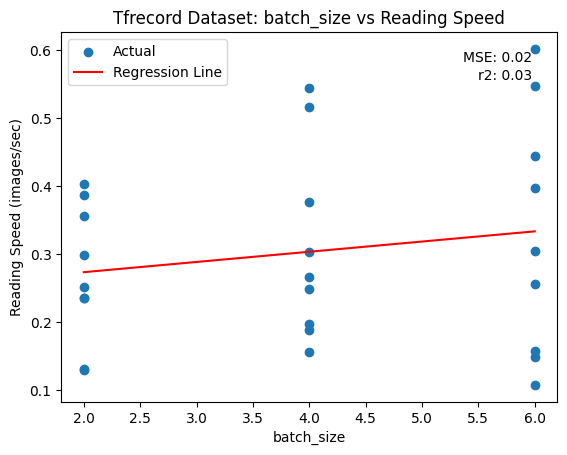

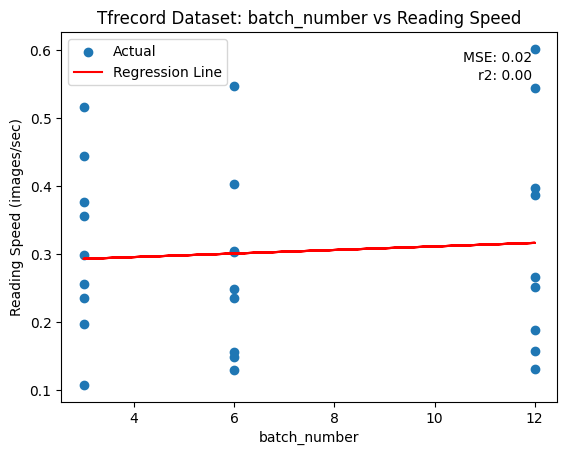

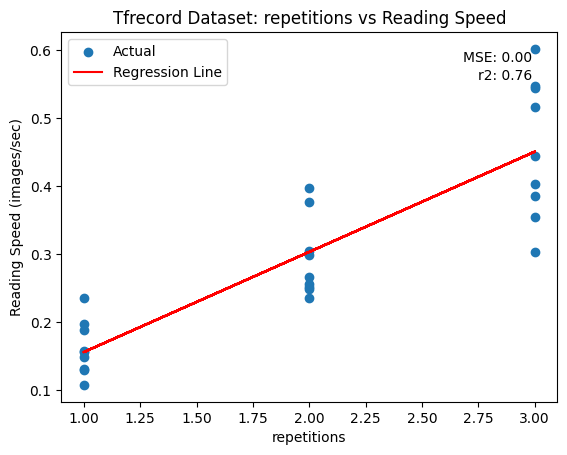

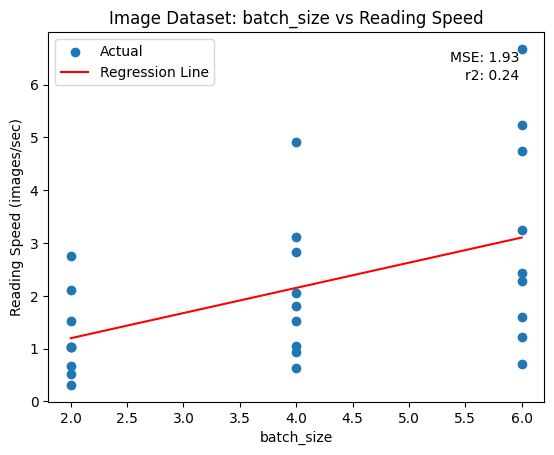

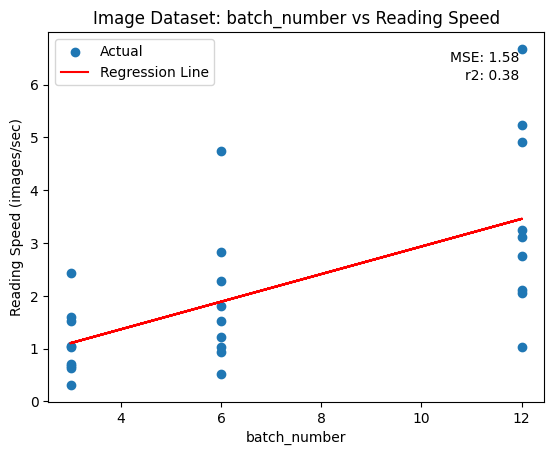

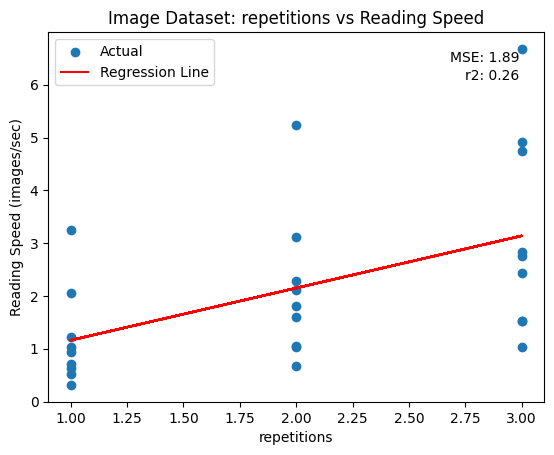

In [85]:
import subprocess
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Function to read pickle files from GCS and convert them to Pandas DataFrames
def read_pickle_from_gcs(file_name):
    command = f"gsutil cp {BUCKET}/{file_name} {file_name}"
    subprocess.run(command, shell=True, check=True)

    with open(file_name, 'rb') as f:
        data = pickle.load(f)

    return data

# Read results from GCS storage bucket and convert them to Pandas DataFrames
tfrecord_results = read_pickle_from_gcs('tfrecord_results.pickle')
images_results = read_pickle_from_gcs('images_results.pickle')

# Create a DataFrame with the results
def create_dataframe_from_results(results, dataset_type):
    results_list = []

    for result in results['results']:
        reading_speed, throughput, params = result
        batch_size, batch_number, repetitions = params
        results_list.append({
            'dataset_type': dataset_type,
            'batch_size': batch_size,
            'batch_number': batch_number,
            'repetitions': repetitions,
            'reading_speed': reading_speed,
            'throughput': throughput
        })

    return pd.DataFrame(results_list)

# Create DataFrames for both dataset types
df_tfrecord = create_dataframe_from_results(tfrecord_results, 'tfrecord')
df_images = create_dataframe_from_results(images_results, 'image')

# Concatenate DataFrames
results_df = pd.concat([df_tfrecord, df_images])

# Function to plot linear regression
def plot_linear_regression(df, dataset_type, parameter):
    filtered_df = df[df['dataset_type'] == dataset_type]

    X = filtered_df[[parameter]] # different parameters to be plotted
    y = filtered_df['reading_speed']

    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)

    # Calculating mean squared error metric
    mse = mean_squared_error(y, predictions)
    # calculating the r-squared metric
    r_squared = r2_score(y, predictions) 
    # Plots the graph and add mean squared error and r-squared to top right corner
    fig, ax = plt.subplots()
    ax.scatter(X, y, label='Actual')
    ax.plot(X, predictions, color='red', label='Regression Line')
    ax.set_title(f"{dataset_type.capitalize()} Dataset: {parameter} vs Reading Speed")
    ax.set_xlabel(parameter)
    ax.set_ylabel("Reading Speed (images/sec)")
    ax.legend()
    ax.text(0.95, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.90, f"r2: {r_squared:.2f}", transform=ax.transAxes, ha='right', va='top')
    plt.show()
# Plot linear regressions for all parameters and dataset types
dataset_types = ['tfrecord', 'image']
parameters = ['batch_size', 'batch_number', 'repetitions']

for dataset_type in dataset_types:
    for parameter in parameters:
        plot_linear_regression(results_df, dataset_type, parameter)

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task. 

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report. 


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit. 

In [7]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket 
!gsutil rb $BUCKET # delete the bucket

Removing gs://disco-order-385609-storage/preprocessed_images-partition-12.tfrecord#1683440172479159...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-10.tfrecord#1683440170904871...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-0.tfrecord#1683440167222981...
Removing gs://disco-order-385609-storage/images_results.pickle#1683446064762450...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-1.tfrecord#1683440162117115...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-13.tfrecord#1683440173216102...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-11.tfrecord#1683440172171773...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-14.tfrecord#1683440174979148...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-15.tfrecord#1683440173974710...
Removing gs://disco-order-385609-storage/preprocessed_images-partition-2.tfrecord#1683440163307